In [1]:
from fastai.datasets import URLs, untar_data

from fastai.vision import *

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
tfms = get_transforms(do_flip=False)
data = (ImageList.from_folder(path)
        .split_by_folder()
        .label_empty()
        .add_test_folder()
        .transform(tfms = tfms, size=64)
        .databunch())

In [5]:
class VAE(nn.Module):
    """Variational Autoencoder with spatial broadcast decoder.
    Shape:
        - Input: :math:`(N, C_{in}, H_{in}, W_{in})`
        - Output: :math:`(N, C_{in}, H_{in}, W_{in})`
    """
    def __init__(self, im_size, decoder='sbd'):
        super(VAE, self).__init__()
        enc_convs = [nn.Conv2d(in_channels=3, out_channels=64,
                               kernel_size=4, stride=2, padding=1)]
        enc_convs.extend([nn.Conv2d(in_channels=64, out_channels=64,
                                    kernel_size=4, stride=2, padding=1)
                          for i in range(3)])
        self.enc_convs = nn.ModuleList(enc_convs)

        self.fc = nn.Sequential(nn.Linear(in_features=1024, out_features=256),
                                nn.ReLU(),
                                nn.Linear(in_features=256, out_features=20))

        if decoder == 'deconv':
            self.dec_linear = nn.Linear(in_features=10, out_features=256)
            dec_convs = [nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                            kernel_size=4, stride=2, padding=1)
                         for i in range(4)]
            self.dec_convs = nn.ModuleList(dec_convs)
            self.decoder = self.deconv_decoder
            self.last_conv = nn.ConvTranspose2d(in_channels=64, out_channels=3,
                                                kernel_size=4, stride=2,
                                                padding=1)

        elif decoder == 'sbd':
            # Coordinates for the broadcast decoder
            self.im_size = im_size
            x = torch.linspace(-1, 1, im_size)
            y = torch.linspace(-1, 1, im_size)
            x_grid, y_grid = torch.meshgrid(x, y)
            # Add as constant, with extra dims for N and C
            self.register_buffer('x_grid', x_grid.view((1, 1) + x_grid.shape))
            self.register_buffer('y_grid', y_grid.view((1, 1) + y_grid.shape))

            dec_convs = [nn.Conv2d(in_channels=12, out_channels=64,
                                   kernel_size=3, padding=1),
                         nn.Conv2d(in_channels=64, out_channels=64,
                                   kernel_size=3, padding=1)]
            self.dec_convs = nn.ModuleList(dec_convs)
            self.decoder = self.sb_decoder
            self.last_conv = nn.Conv2d(in_channels=64, out_channels=3,
                                       kernel_size=3, padding=1)

    def encoder(self, x):
        batch_size = x.size(0)
        for module in self.enc_convs:
            x = F.relu(module(x))

        x = x.view(batch_size, -1)
        x = self.fc(x)

        return torch.chunk(x, 2, dim=1)

    def deconv_decoder(self, z):
        x = F.relu(self.dec_linear(z)).view(-1, 64, 2, 2)
        for module in self.dec_convs:
            x = F.relu(module(x))
        x = self.last_conv(x)

        return x

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def sb_decoder(self, z):
        batch_size = z.size(0)
        # View z as 4D tensor to be tiled across new H and W dimensions
        # Shape: NxDx1x1
        z = z.view(z.shape + (1, 1))

        # Tile across to match image size
        # Shape: NxDx64x64
        z = z.expand(-1, -1, self.im_size, self.im_size)

        # Expand grids to batches and concatenate on the channel dimension
        # Shape: Nx(D+2)x64x64
        x = torch.cat((self.x_grid.expand(batch_size, -1, -1, -1),
                       self.y_grid.expand(batch_size, -1, -1, -1), z), dim=1)

        for module in self.dec_convs:
            x = F.relu(module(x))
        x = self.last_conv(x)

        return x

    def forward(self, x):
        batch_size = x.size(0)
        mu, logvar = self.encoder(x)
        z = self.sample(mu, logvar)
        x_rec = self.decoder(z)

        kl = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).sum(dim=-1).mean()
        mse_loss = F.mse_loss(x_rec, x, reduction='none').view(batch_size, -1)
        mse_loss = 10 * mse_loss.sum(dim=-1).mean()
        
        output = {"mse": mse_loss, "kl":kl, "x_rec":x_rec}

        return output

In [10]:
def loss(output,y):
    mse = output["mse"]
    kl = output["kl"]
    
    l = mse + kl
    return l

In [47]:
x,y = data.one_batch()

In [48]:
output = model(x)

In [7]:
from fastai.basic_train import Learner

In [11]:
model = VAE(im_size=64)
learner = Learner(data,model,loss_func = loss)

In [52]:
learner.save()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [87]:
learner.model.cuda()

VAE(
  (enc_convs): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=20, bias=True)
  )
  (dec_convs): ModuleList(
    (0): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (last_conv): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [98]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


OSError: [Errno 12] Cannot allocate memory

In [89]:
learner.model.cpu()

VAE(
  (enc_convs): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=20, bias=True)
  )
  (dec_convs): ModuleList(
    (0): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (last_conv): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt

In [90]:
m(x)["x_rec"][0]

tensor([[[-0.0074, -0.0286, -0.0179,  ...,  0.0076,  0.0259,  0.0157],
         [-0.0297, -0.0445, -0.0377,  ...,  0.0296,  0.0356,  0.0280],
         [-0.0052, -0.0113, -0.0132,  ...,  0.0077,  0.0086,  0.0093],
         ...,
         [ 0.0306,  0.0059, -0.0255,  ...,  0.0450,  0.0415,  0.0032],
         [ 0.0839,  0.0582,  0.0269,  ...,  0.0370,  0.0065,  0.0098],
         [ 0.0672,  0.0402,  0.0229,  ...,  0.0160,  0.0061, -0.0185]],

        [[ 0.0103,  0.0011, -0.0033,  ...,  0.0045, -0.0084, -0.0120],
         [-0.0161, -0.0172, -0.0099,  ..., -0.0013, -0.0047, -0.0127],
         [-0.0034,  0.0121,  0.0122,  ..., -0.0036,  0.0003,  0.0006],
         ...,
         [ 0.0383,  0.0201, -0.0018,  ...,  0.0273,  0.0211, -0.0096],
         [ 0.0872,  0.0735,  0.0593,  ...,  0.0246,  0.0041, -0.0101],
         [ 0.0319,  0.0350,  0.0551,  ..., -0.0108,  0.0065,  0.0399]],

        [[-0.0055, -0.0182, -0.0159,  ..., -0.0009,  0.0009,  0.0194],
         [-0.0083,  0.0110,  0.0063,  ...,  0

In [91]:
img = m(x)["x_rec"][0].permute(1,2,0).detach().numpy()

In [92]:
original = x[0].permute(1,2,0).numpy()

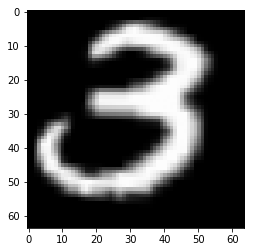

In [93]:
plt.imshow(original)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


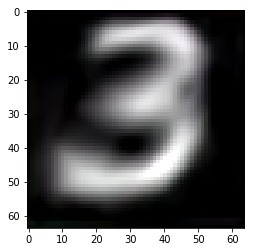

In [94]:

plt.imshow(img)

In [59]:
learner = learner.to_fp32()

In [58]:
learner.fit_one_cycle(1,1e-3)

epoch,train_loss,valid_loss,time


AttributeError: 'dict' object has no attribute 'dtype'

In [0]:
class test(nn.Module):
  def __init__(self):
    super(test,self).__init__()
    self.layer = nn.ModuleList([nn.Linear(2,2),nn.ReLU()])
    
  def forward(self,x):
    for l in self.layer:
      x = l(x)
    return x

In [33]:
e(x).shape

torch.Size([5, 8, 56, 56])

In [21]:
x = torch.tensor([[1,2],[3,4]]).float()
x * x

tensor([[ 1.,  4.],
        [ 9., 16.]])

In [28]:
t = ConvWithActivation()
t(x).shape

torch.Size([5, 8, 62, 62])

In [0]:
(x * x).sum().backward()

tensor([[2., 4.],
        [6., 8.]])